#### Import Package

In [208]:
import os
import numpy as np
import pandas as pd
import quantstats as qs
import matplotlib.pyplot as plt

from core.system import *
from core.operation import *

import warnings

warnings.filterwarnings('ignore')

#### Load Data

In [209]:
# Params
start = '2005-01-01'
current_date = (date.today()).strftime('%Y-%m-%d')
etf_list = ['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU']

In [210]:
# Read in ETF data from FMP
T = [1]
sector_ret = get_data_fmp(ticker_list=etf_list, start=start, current_date=current_date)
sector_ret = sector_ret[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
sector_ret = sector_ret.rename(columns={'Adj Close': 'Close'})
sector_ret = sector_ret.loc[~sector_ret.index.duplicated(keep='first')]

Fetching data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.70s/ticker]


In [211]:
# # Read in ETF data from FMP
# sector_fund = get_fund_fmp(ticker_list=etf_list, start=start, current_date=current_date)

In [212]:
# Create returns
sector_ret = create_return(sector_ret, T)
sector_info = sector_ret.copy(deep=True)
sector_ret = sector_ret.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
sector_ret = sector_ret.dropna()

#### Correlation

In [213]:
def corr_table(df):
    df = df.unstack('ticker').swaplevel(axis=1)
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    df = df.fillna(0)
    correlation_matrix = df.corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    correlation_matrix_masked = correlation_matrix.mask(mask)
    formatted_corr_matrix = correlation_matrix_masked.applymap(lambda x: f"{x:.4f}" if np.isfinite(x) else "")
    return formatted_corr_matrix

In [214]:
corr_table(sector_ret)

,XLB_RET_01,XLE_RET_01,XLF_RET_01,XLI_RET_01,XLK_RET_01,XLP_RET_01,XLU_RET_01,XLV_RET_01,XLY_RET_01
XLB_RET_01,,,,,,,,,
XLE_RET_01,0.7556,,,,,,,,
XLF_RET_01,0.7364,0.6296,,,,,,,
XLI_RET_01,0.8663,0.7164,0.8059,,,,,,
XLK_RET_01,0.7469,0.5856,0.7012,0.7942,,,,,
XLP_RET_01,0.6505,0.5089,0.6278,0.7160,0.6783,,,,
XLU_RET_01,0.5796,0.5176,0.5148,0.6022,0.5494,0.7051,,,
XLV_RET_01,0.6882,0.5474,0.6418,0.7407,0.7212,0.7347,0.6103,,
XLY_RET_01,0.7609,0.5864,0.7666,0.8323,0.8443,0.6870,0.5366,0.7022,


#### Statistics

In [215]:
# Unstack 
stat = sector_ret.unstack('ticker')['RET_01']

In [216]:
# Get positive/negative return count
pos = []
neg = []
tickers = []
for ticker in stat.columns:
    pos.append(len(stat.loc[stat[ticker] > 0]))
    neg.append(len(stat.loc[stat[ticker] < 0]))
    tickers.append(ticker)
pos_neg_ret = pd.DataFrame(data={'pos':pos, 'neg':neg}, index=tickers)
pos_neg_ret

,pos,neg
XLB,2560,2203
XLE,2508,2280
XLF,2462,2247
XLI,2592,2164
XLK,2618,2125
XLP,2551,2153
XLU,2566,2171
XLV,2557,2185
XLY,2588,2182


#### Random Long/Short Portfolio

In [238]:
# Random
random_ret = sector_ret.copy(deep=True)
random_ret['signal'] = np.random.choice([-1, 1], size=len(sector_ret))
norm_factor = random_ret.groupby('date')['signal'].transform(lambda x: np.sum(np.abs(x)))
random_ret['nrom_signal'] = random_ret['signal'] / norm_factor
random_ret = random_ret.groupby('date').apply(lambda x: (x['nrom_signal'] * x['RET_01']).sum())

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-01-05   2005-01-05
End Period                 2024-03-05   2024-03-05
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          326.81%      -14.02%
CAGR﹪                     5.36%        -0.54%

Sharpe                     0.49         -0.07
Prob. Sharpe Ratio         98.36%       38.19%
Smart Sharpe               0.47         -0.07
Sortino                    0.69         -0.09
Smart Sortino              0.66         -0.09
Sortino/√2                 0.49         -0.07
Smart Sortino/√2           0.46         -0.06
Omega                      0.99         0.99

Max Drawdown               -56.47%      -39.16%
Longest DD Days            1982         6980
Volatility (ann.)          19.3%        7.45%
R^2                        0.0          0.0
Information Ratio          -0.03        -0.03
Calmar      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2005-01-25,2020-05-04,2024-03-05,6980,-39.163912,-35.935136
2,2005-01-20,2005-01-20,2005-01-21,2,-0.175143,-0.041241
3,2005-01-07,2005-01-10,2005-01-10,4,-0.135278,-0.095892
4,2005-01-18,2005-01-18,2005-01-18,1,-0.025129,NaN


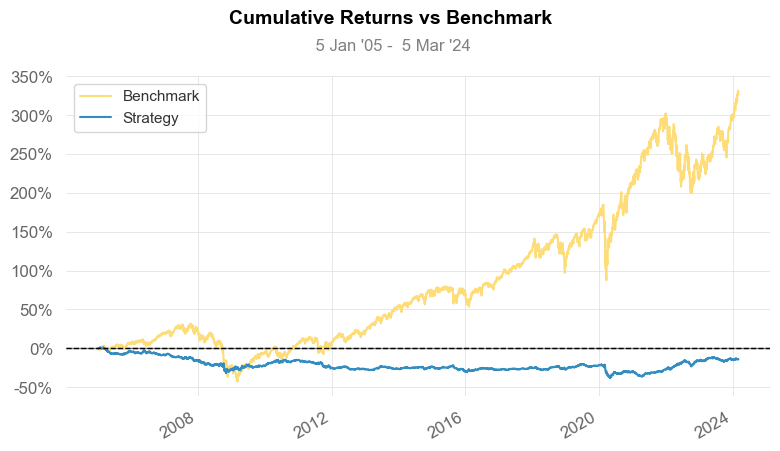

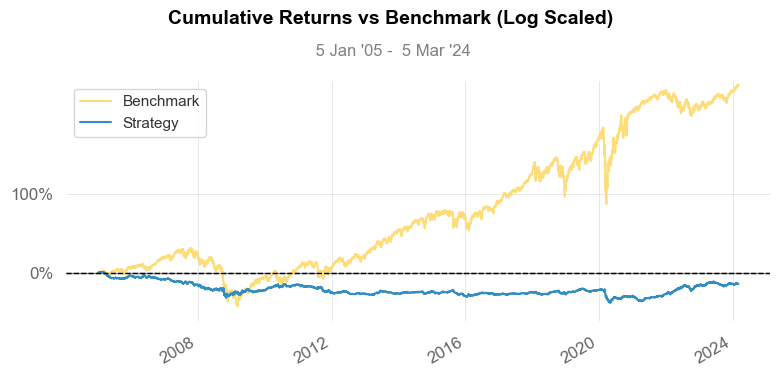

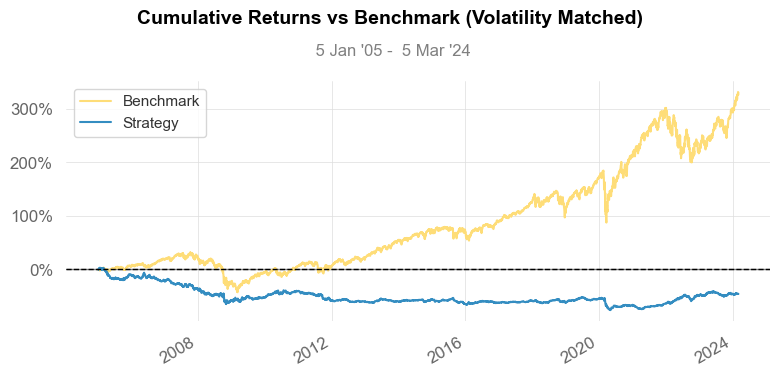

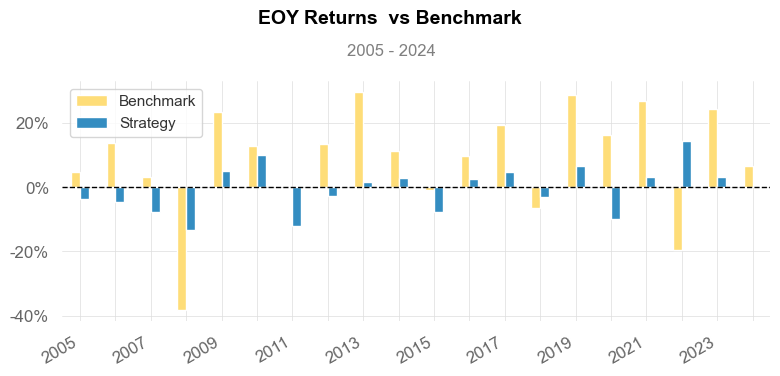

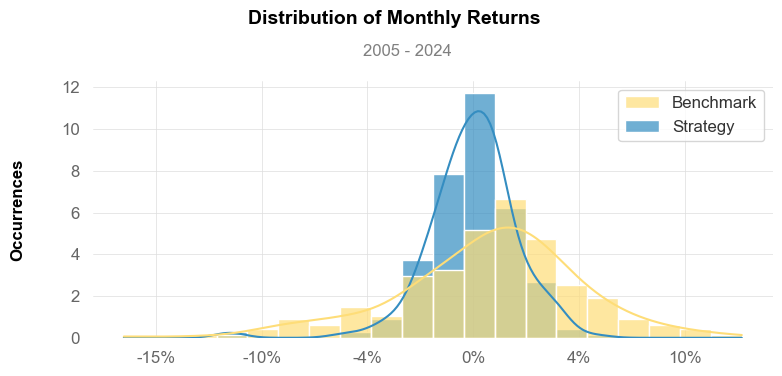

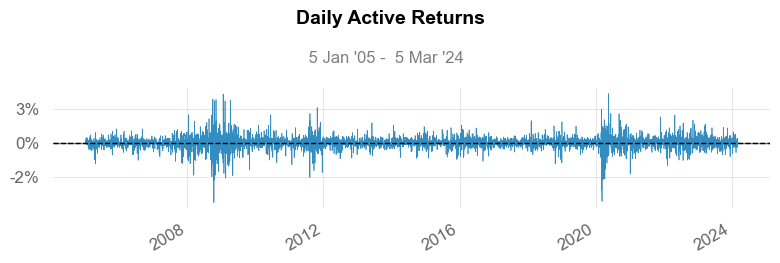

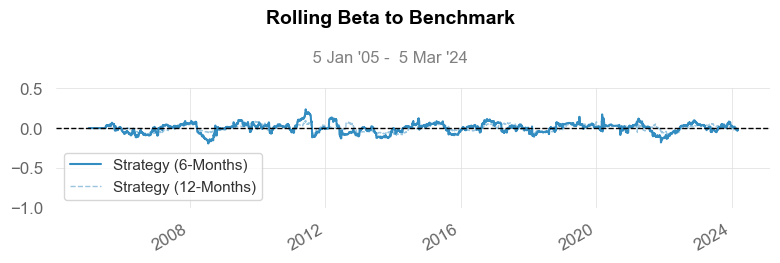

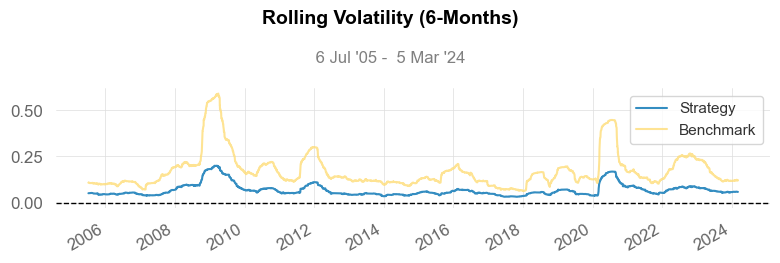

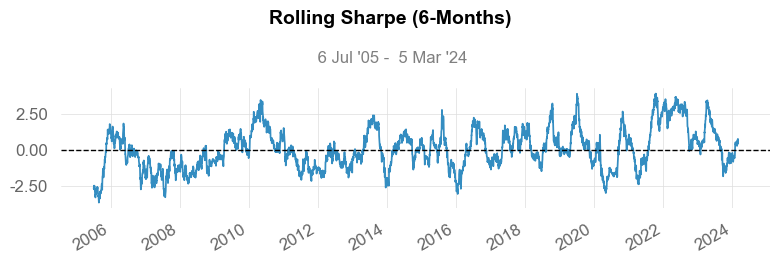

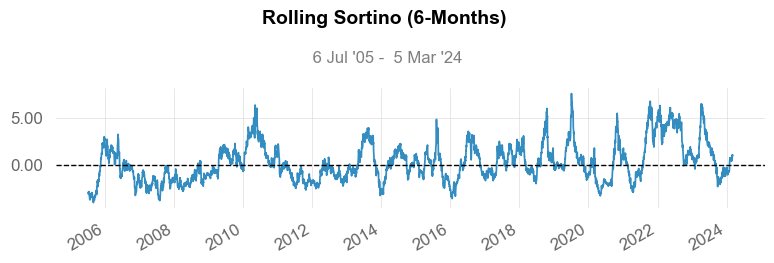

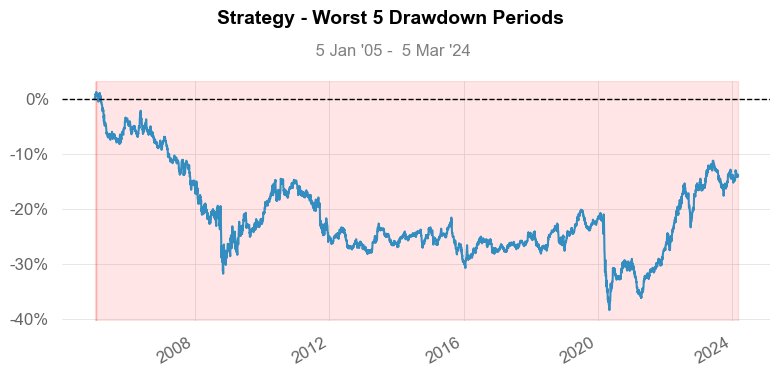

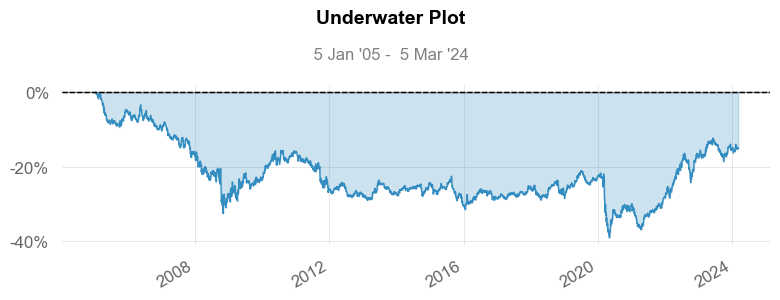

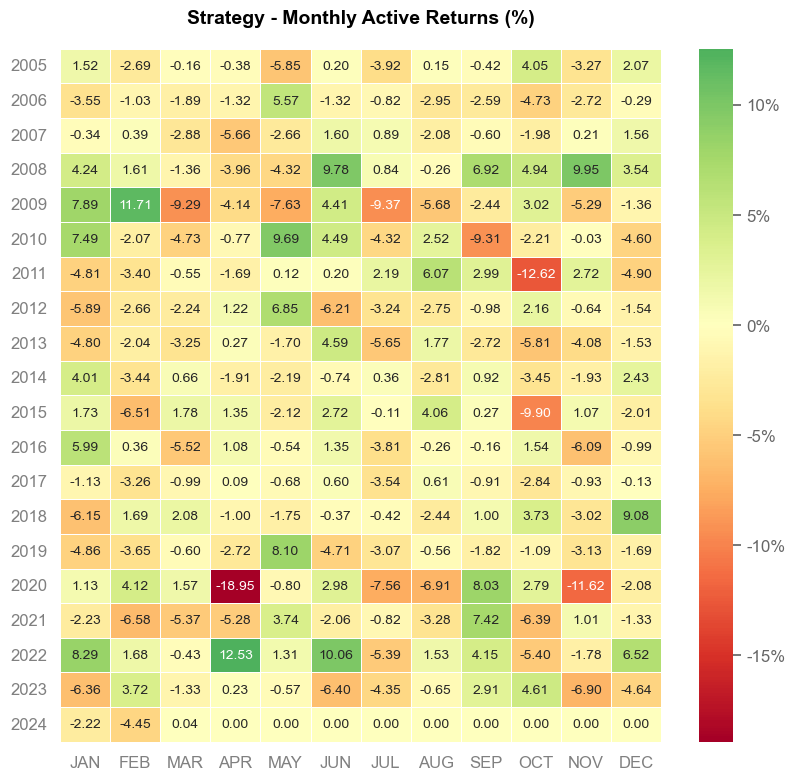

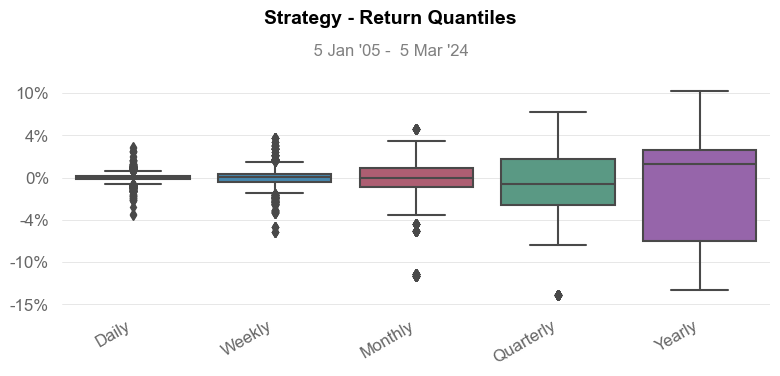

In [239]:
# Report
qs.reports.full(random_ret, 'SPY')

#### EWP Long-Only Portfolio

In [222]:
# EWP
ewp_weight = 1 / len(sector_ret.index.get_level_values('ticker').unique())
ewp_ret = sector_ret.groupby('date').apply(lambda x: (ewp_weight * x['RET_01']).sum())

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-01-05   2005-01-05
End Period                 2024-03-05   2024-03-05
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          326.81%      531.29%
CAGR﹪                     5.36%        6.86%

Sharpe                     0.49         0.61
Prob. Sharpe Ratio         98.36%       99.58%
Smart Sharpe               0.44         0.55
Sortino                    0.69         0.85
Smart Sortino              0.62         0.77
Sortino/√2                 0.49         0.6
Smart Sortino/√2           0.44         0.54
Omega                      1.13         1.13

Max Drawdown               -56.47%      -52.53%
Longest DD Days            1982         1220
Volatility (ann.)          19.3%        18.77%
R^2                        0.96         0.96
Information Ratio          0.03         0.03
Calmar             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-10-15,2009-03-09,2011-02-15,1220,-52.530458,-47.929190
2,2020-02-20,2020-03-23,2020-11-06,261,-36.904274,-31.774678
3,2011-07-08,2011-10-03,2012-02-02,210,-18.614514,-16.957158
4,2018-09-24,2018-12-24,2019-04-11,200,-18.470306,-15.143610
5,2022-03-30,2022-09-30,2023-07-11,469,-16.943431,-16.049988


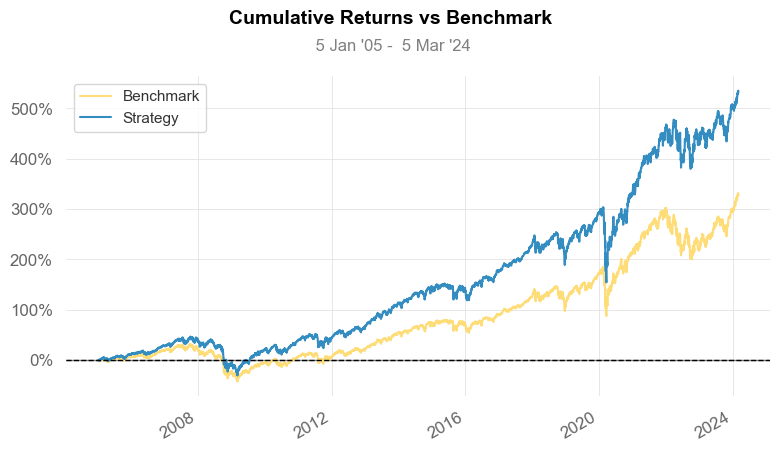

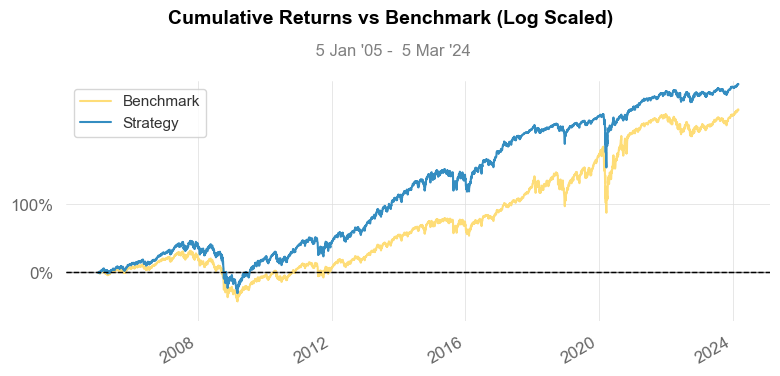

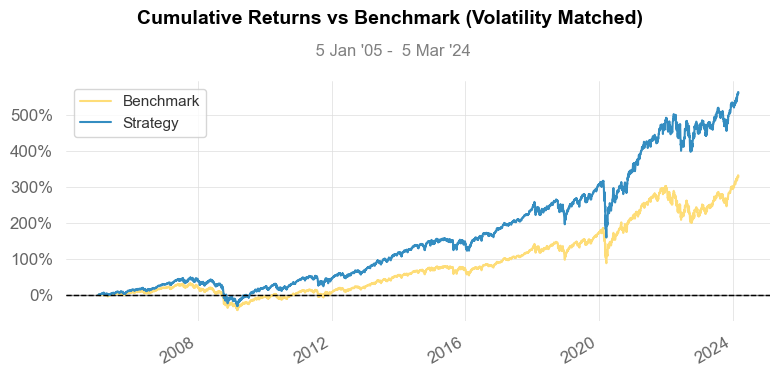

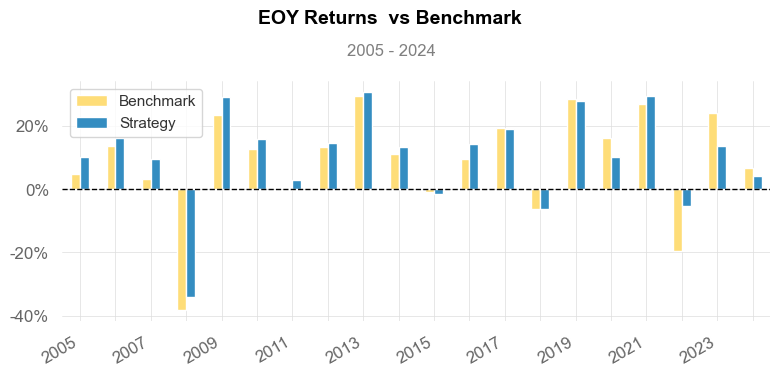

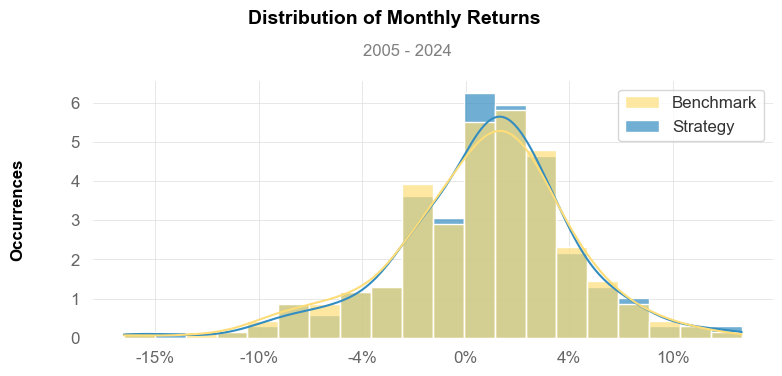

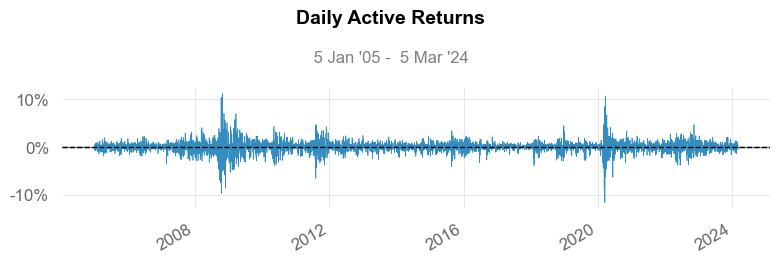

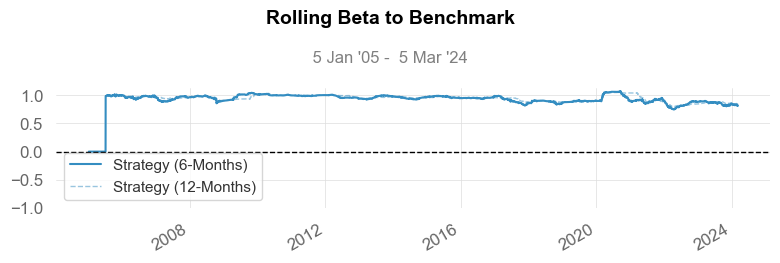

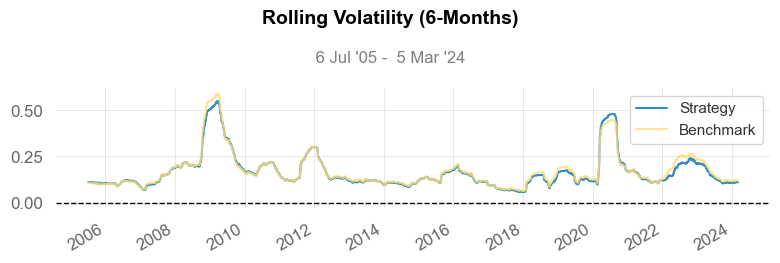

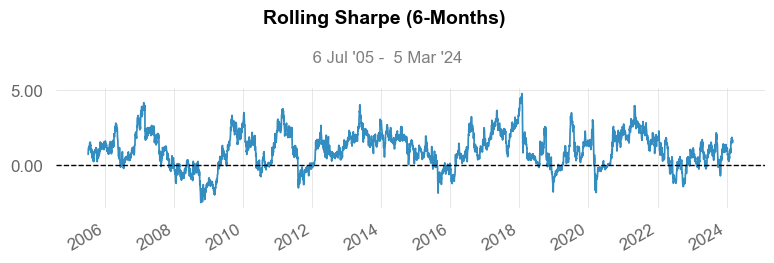

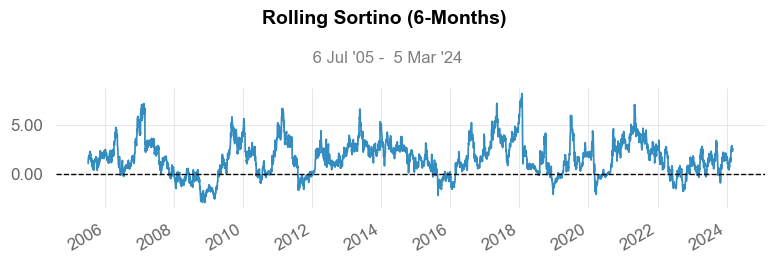

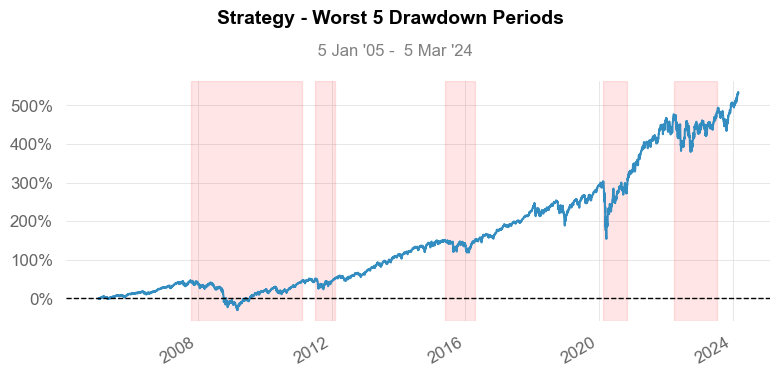

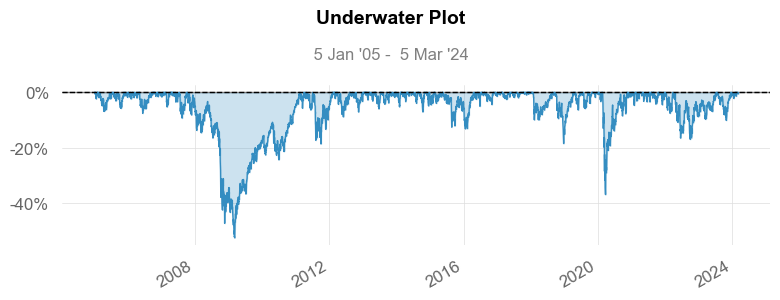

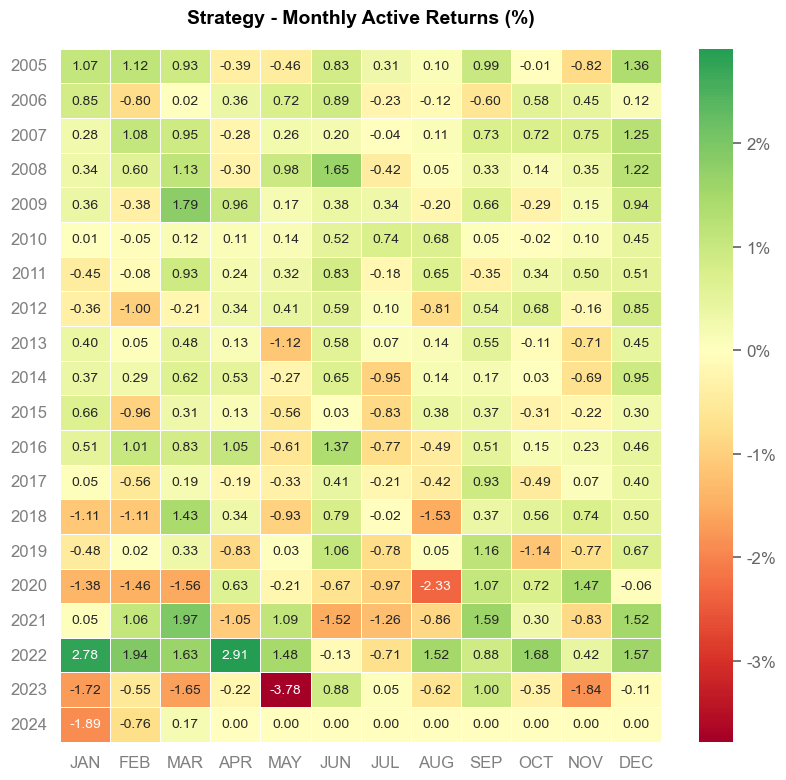

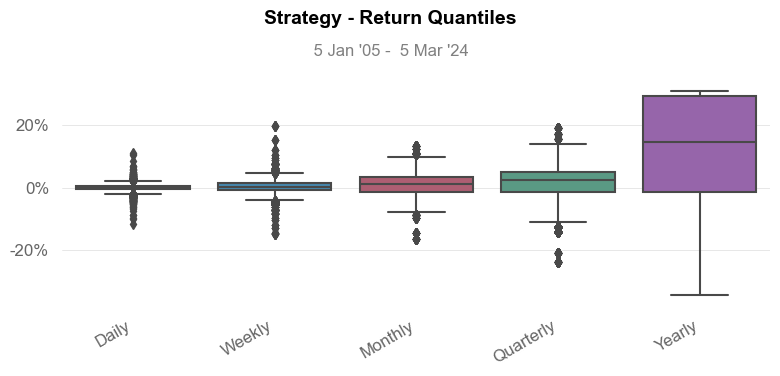

In [223]:
# Report
qs.reports.full(ewp_ret, 'SPY')

#### Beta Premia

In [217]:
# Read in SPY data from FMP
T = [1]
spy = get_data_fmp(ticker_list=['SPY'], start=start, current_date=current_date)
spy = spy[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
spy = spy.rename(columns={'Adj Close': 'Close'})

Fetching data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.79s/ticker]


In [218]:
# Create returns and unstack dataframe to only have 'date' index
spy = create_return(spy, T)
spy = spy.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
spy = spy.unstack('ticker').swaplevel(axis=1)
spy.columns = ['_'.join(col).strip() for col in spy.columns.values]
spy = spy.fillna(0)

In [219]:
# Execute Rolling OLS
T = [1]
window = 21
ret = f'RET_01'
factor_col_spy = spy.columns
beta_spy = rolling_ols_parallel(data=sector_ret, ret=ret, factor_data=spy, factor_cols=factor_col_spy.tolist(), window=window, name=f'spy_01')
defense = beta_spy[[f'SPY_RET_01_spy_01_{window}']]
defense.columns = ['beta']
defense = defense.dropna()

#### Momentum Premia

In [220]:
# Compute Mom Season
def compute_mom(group):
    for n in range(23, 60, 12):
        group[f'temp{n}'] = group['RET_01'].shift(n)

    group['retTemp1'] = group[[col for col in group.columns if 'temp' in col]].sum(axis=1, skipna=True)
    group['retTemp2'] = group[[col for col in group.columns if 'temp' in col]].count(axis=1)
    group['mom_season'] = group['retTemp1'] / group['retTemp2']
    return group[['mom_season']]
    
mom = sector_ret.copy(deep=True)
mom = mom.groupby('ticker').apply(compute_mom).reset_index(level=0, drop=True)
mom = mom.dropna()

In [221]:
def compute_momentum(x):
    return ((1 + x['RET_01'].shift(1)) * (1 + x['RET_01'].shift(2)) * (1 + x['RET_01'].shift(3))
            * (1 + x['RET_01'].shift(4)) * (1 + x['RET_01'].shift(5)) - 1)

mom_vol = sector_info.copy(deep=True)
mom_vol['Mom6m'] = mom_vol.groupby('ticker').apply(compute_momentum).reset_index(level=0, drop=True)
mom_vol = mom_vol.fillna(0)
mom_vol['catMom'] = mom_vol.groupby('date')['Mom6m'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))
mom_vol['temp'] = mom_vol.groupby('ticker')['Volume'].transform(lambda x: x.rolling(window=6, min_periods=5).mean())
mom_vol = mom_vol.fillna(0)
mom_vol['catVol'] = mom_vol.groupby('date')['temp'].transform(lambda x: pd.qcut(x, 3, labels=False, duplicates='drop'))
mom_vol['mom_vol'] = mom_vol.apply(lambda x: x['catMom'] if x['catVol'] == 2 else None, axis=1)
mom_vol['mom_vol'] = mom_vol.groupby(['ticker', 'date']).cumcount().where(lambda x: x >= 24, mom_vol['mom_vol'])
mom_vol = mom_vol[['mom_vol']]

#### Risk Premia Portfolio

In [224]:
# Join
risk_premia = defense.join(sector_ret)
risk_premia = risk_premia.join(mom)
risk_premia = risk_premia.join(mom_vol)
risk_premia = risk_premia.dropna()

In [228]:
# Function to select top and bottom stocks
def select_long_short_stocks(group):
    top_stocks = group.nlargest(1, 'adj_weight')
    bottom_stocks = group.nsmallest(1, 'adj_weight')
    top_stocks['final_weight'] = top_stocks['adj_weight'] * 1
    bottom_stocks['final_weight'] = bottom_stocks['adj_weight'] * -1
    return pd.concat([top_stocks, bottom_stocks])

# Create Factor-Based Portfolio
def create_factor_port(data, factors):
    df = data.copy(deep=True)
    # Create ranks for each factor
    print("-"*60)
    print("Creating Factor Ranks...")
    for factor_name in factors:
        print(f'Factor: {factor_name}')
        df[f'{factor_name}_Rank'] = df.groupby('date')[factor_name].rank(ascending=False)
    # Calculating average rank
    df['avg_rank'] = df[[f'{f}_Rank' for f in factors]].mean(axis=1)
    # Calculating rank weights
    df['rank_weight'] = (1 / len(factors)) * df['avg_rank']
    # Calculating inverse volatility
    df['vol'] = df.groupby('ticker')['RET_01'].transform(lambda x: x.rolling(7).std().shift(1))
    df['inv_vol_weight'] = 1 / df['vol']
    # Find adjusted weight that accounts for rank and inverse volatility
    df['adj_weight'] = df['rank_weight'] * df['inv_vol_weight']
    # Selecting Top and Bottom Stocks
    print("-"*60)
    print("Creating Long/Short portfolio...")
    top_bottom_stocks = df.groupby('date').apply(select_long_short_stocks).reset_index(level=0, drop=True)
    # Normalizing Weights
    top_bottom_stocks['final_weight'] /= top_bottom_stocks.groupby('date')['final_weight'].transform(lambda x: x.abs().sum())
    # Shift returns
    top_bottom_stocks['RET_01'] = top_bottom_stocks.groupby('ticker')['RET_01'].shift(-1)
    top_bottom_stocks['total_ret'] = top_bottom_stocks['RET_01'] * top_bottom_stocks['final_weight']
    total_ret = top_bottom_stocks.groupby('date').total_ret.sum()
    qs.reports.full(total_ret, 'SPY')
    return total_ret

------------------------------------------------------------
Creating Factor Ranks...
Factor: mom_season
Factor: mom_vol
------------------------------------------------------------
Creating Long/Short portfolio...
[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-02-16   2005-02-16
End Period                 2024-03-05   2024-03-05
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          318.71%      63.7%
CAGR﹪                     5.32%        1.8%

Sharpe                     0.49         0.23
Prob. Sharpe Ratio         98.27%       84.54%
Smart Sharpe               0.44         0.21
Sortino                    0.68         0.33
Smart Sortino              0.62         0.3
Sortino/√2                 0.48         0.23
Smart Sortino/√2           0.44         0.21
Omega                      1.05         1.05

Max Drawdown               -56.47%      -51.73%
Longest DD Days            1982         2153
Volatility (ann.)          19.35%       18.31%
R^2                        0.0          0.0
Information Ratio          -0.01        -0.01
Calmar                

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-12-06,2009-03-05,2010-07-21,959,-51.726807,-48.105358
2,2014-12-08,2018-10-23,2020-10-29,2153,-38.617016,-36.702656
3,2020-11-04,2022-10-20,2024-03-05,1218,-30.165422,-28.967463
4,2011-03-14,2012-06-08,2014-03-11,1094,-29.248771,-28.267419
5,2005-03-10,2006-08-07,2007-01-11,673,-13.031299,-12.434595


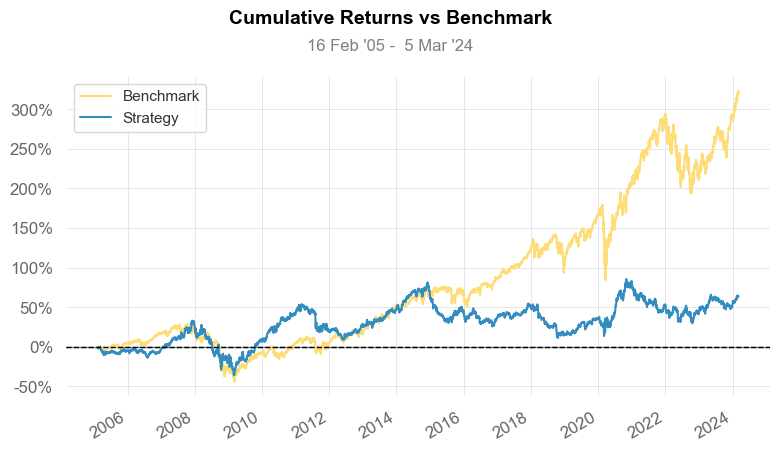

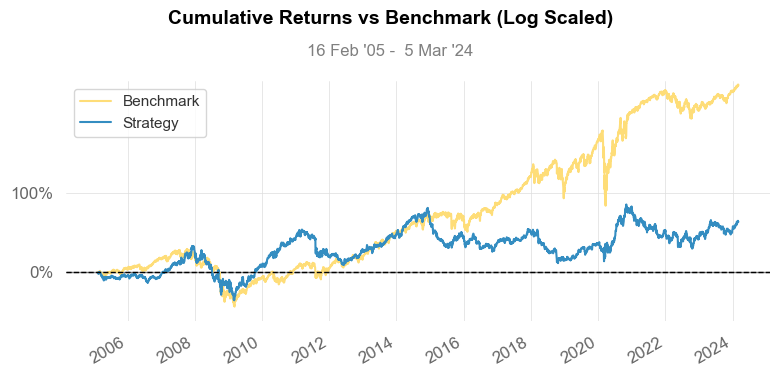

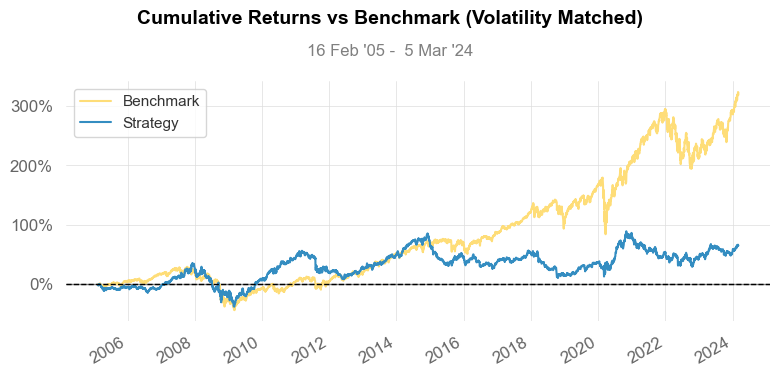

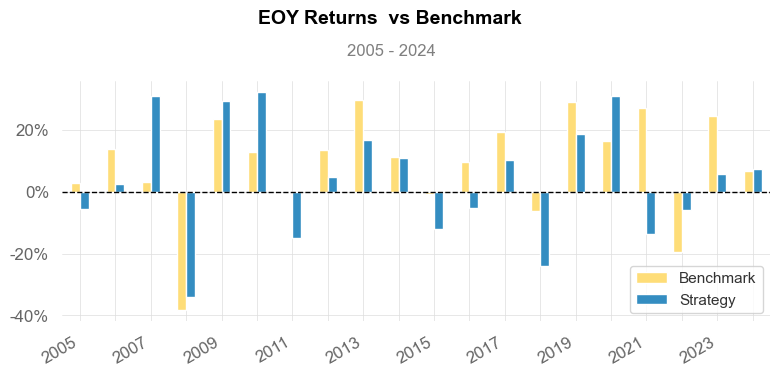

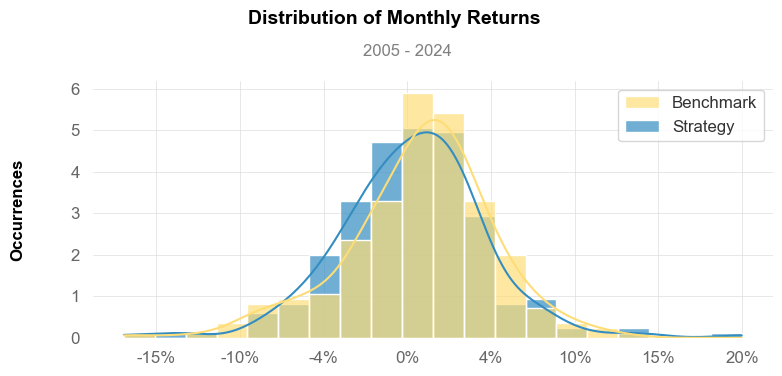

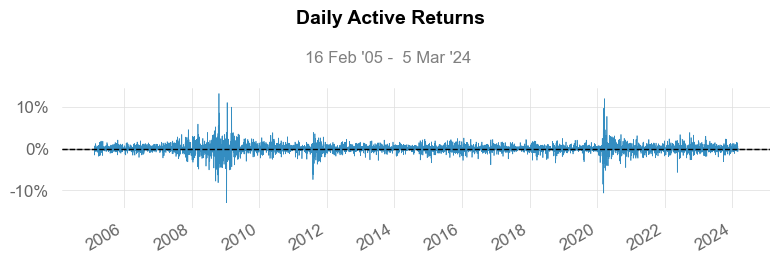

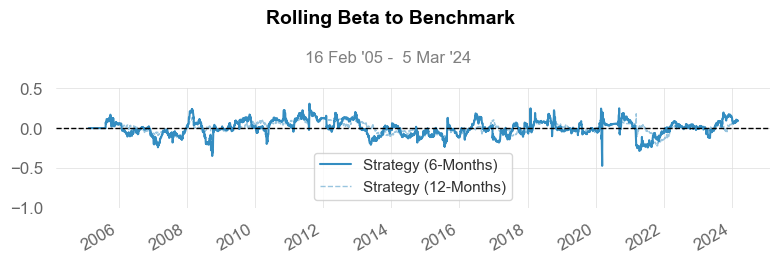

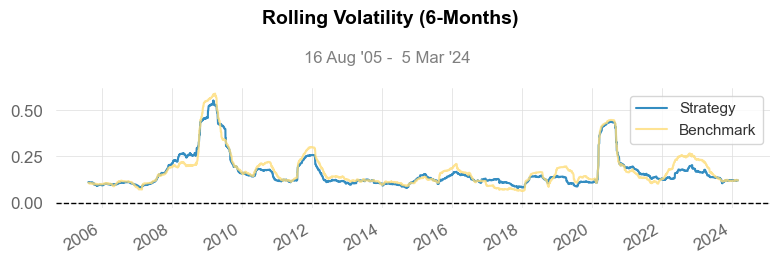

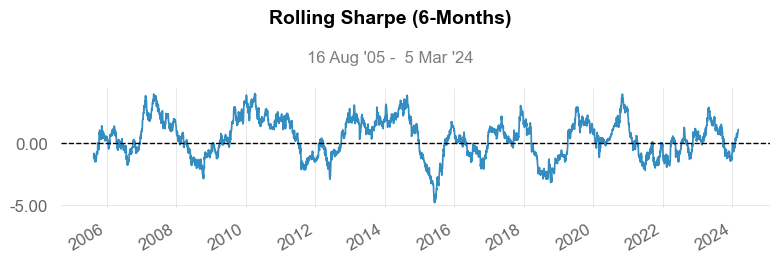

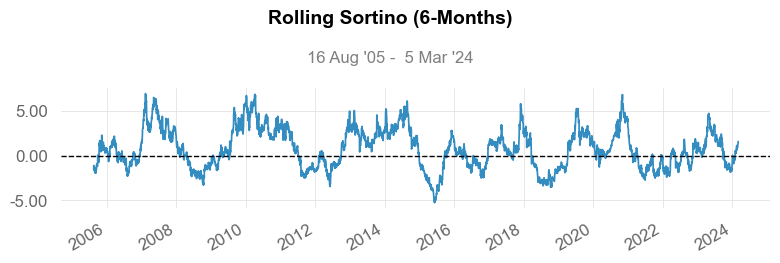

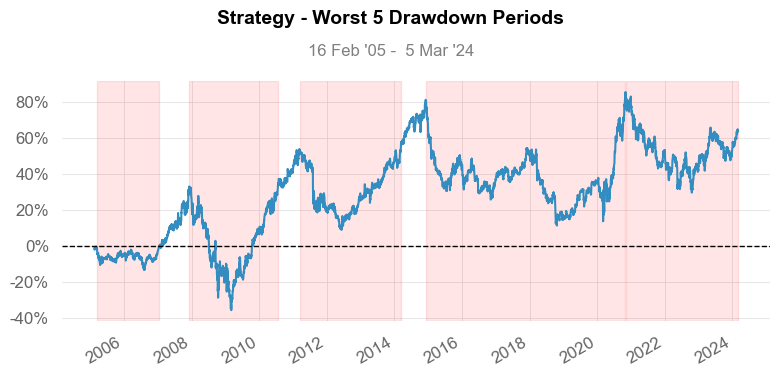

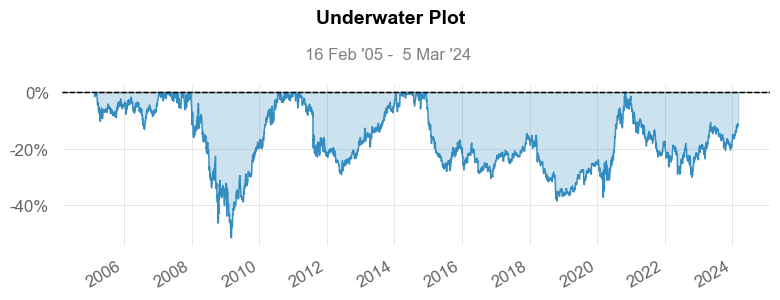

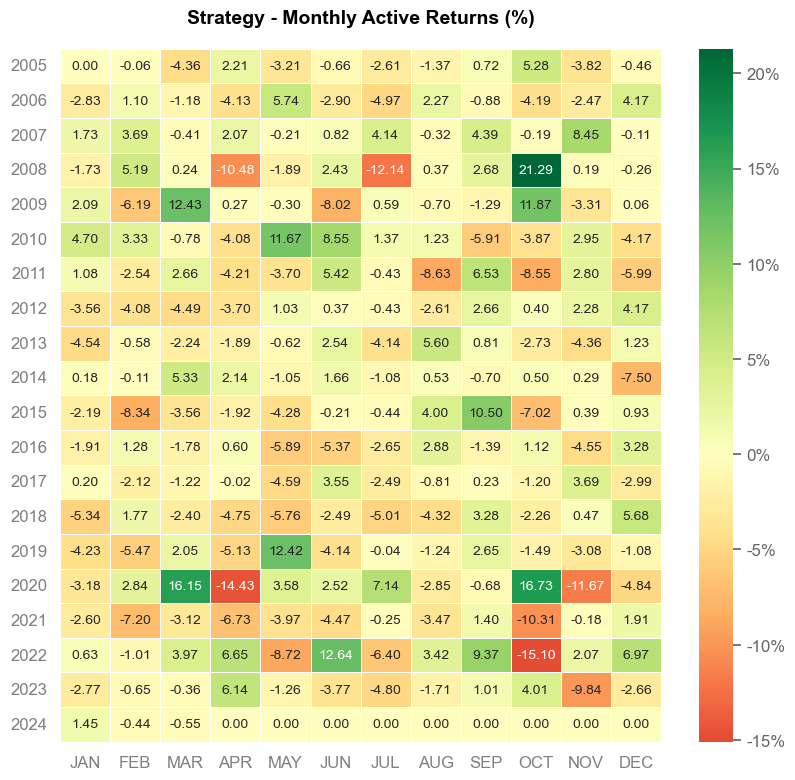

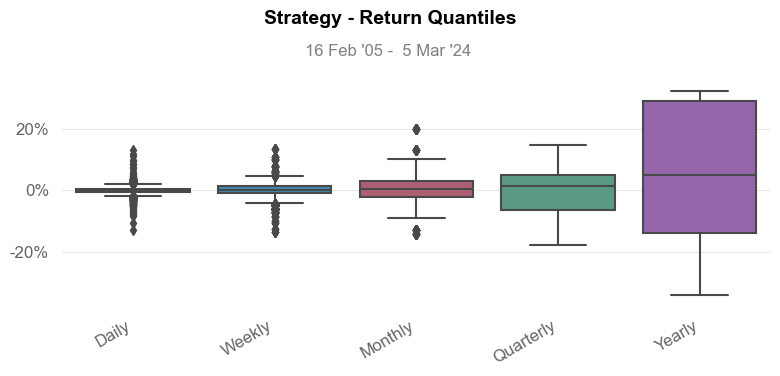

In [229]:
# Calculate portfolio return index
factors = ['mom_season', 'mom_vol']
port_ret = create_factor_port(risk_premia, factors)